In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from core import bw_color_palette
import textwrap

In [3]:
def plot_upset(data, x_list, y, hue, figsize=(8, 6), palette=None, subplot_fraction=0.25,
               lower_bound=None, upper_bound=None, legend_title='', bar_ylabel=None, 
               marker_size=4, legend_text_width=30):
    """
    Creates an UpSet plot using matplotlib.

    Parameters:
    - data: pandas DataFrame containing the data.
    - x_list: list of column names in data representing boolean variables.
    - y: the name of the numeric column in data.
    - hue: the name of the categorical column in data.
    - figsize: tuple specifying the figure size (width, height).
    - palette: list of colors for the bar plot.
    - subplot_fraction: fraction of the figure height allocated to the combination matrix.
    - lower_bound: optional, the name of the column for the lower bound of y.
    - upper_bound: optional, the name of the column for the upper bound of y.

    The function plots a bar for each hue across combinations of x variables,
    with the height of the bar representing the y variable for that hue/x set.
    Error bars are included if lower_bound and upper_bound are provided.
    """
    # Create a 'combination' column that represents the combination of x_list variables
    data['combination'] = data[x_list].apply(lambda row: tuple(row.values), axis=1)

    # Get unique combinations and generate labels
    combinations = data['combination'].unique()
    combination_labels = []
    for comb in combinations:
        label = ' & '.join([x_list[i] for i, val in enumerate(comb) if val])
        if not label:
            label = 'None'
        combination_labels.append(label)

    # Create a DataFrame for combinations
    combination_df = pd.DataFrame({
        'combination': combinations,
        'label': combination_labels
    })
    combination_df['combination_id'] = range(len(combinations))
    combination_dict = {comb: idx for comb, idx in zip(combinations, combination_df['combination_id'])}
    data['combination_id'] = data['combination'].map(combination_dict)

    # Aggregate y (and bounds if provided) per combination_id and hue
    agg_columns = [y]
    if lower_bound and upper_bound:
        agg_columns.extend([lower_bound, upper_bound])

    agg_data = data.groupby(['combination_id', hue])[agg_columns].sum().reset_index()

    # Pivot data to have hues as columns
    agg_pivot = agg_data.pivot(index='combination_id', columns=hue).fillna(0)

    # Compute total y per combination for ordering
    agg_pivot['total_y'] = agg_pivot[y].sum(axis=1)

    # Sort combinations by total y descending
    agg_pivot = agg_pivot.sort_values('total_y', ascending=False)

    # Update combination_df to match sorted combination_ids
    combination_df = combination_df.set_index('combination_id').loc[agg_pivot.index].reset_index()

    # Prepare plotting data
    hues = agg_pivot[y].columns.tolist()
    num_combinations = len(agg_pivot)
    x = np.arange(num_combinations)  # x-axis positions
    width = 0.8 / len(hues)  # width of each bar

    # Prepare colors
    if palette is not None:
        colors = palette
    else:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, (ax_bar, ax_upset) = plt.subplots(
        2, 1, figsize=figsize,
        gridspec_kw={'height_ratios': [1 - subplot_fraction, subplot_fraction]},
        sharex=True
    )

    # Plot bars for each hue with error bars if provided
    for i, hue_value in enumerate(hues):
        y_values = agg_pivot[y][hue_value].values
        color = colors[i % len(colors)]

        # Calculate yerr if bounds are provided
        if lower_bound and upper_bound:
            y_upper = agg_pivot[upper_bound][hue_value].values
            y_lower = agg_pivot[lower_bound][hue_value].values
            y_err = [y_values - y_lower, y_upper - y_values]
        else:
            y_err = None

        ax_bar.bar(x + i*width, y_values, width, label=str(hue_value),
                   edgecolor='black', linewidth=0.5, color=color, yerr=y_err, error_kw={'linewidth': 1})

    # Remove x-axis labels in the bar plot
    ax_bar.set_xticks([])
    if legend_title == '':
        legend_title = hue
    legend = ax_bar.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1))
    # Wrap legend text
    for text in legend.get_texts():
        original_text = text.get_text()
        wrapped_text = "\n".join(textwrap.wrap(original_text, width=legend_text_width))
        text.set_text(wrapped_text)
    if bar_ylabel is None:
        bar_ylabel=y
    ax_bar.set_ylabel(bar_ylabel)

    # Despine ax_bar (remove top and right spines)
    for spine in ['top', 'right']:
        ax_bar.spines[spine].set_visible(False)

    # Plot the combination matrix below the bar plot
    for idx, comb_id in enumerate(agg_pivot.index):
        combination = combination_df.loc[combination_df['combination_id'] == comb_id, 'combination'].values[0]
        for i, val in enumerate(combination):
            if val:
                ax_upset.plot(idx + width * (len(hues)-1)/2,
                              len(x_list) - i - 1, 'ko', markersize=marker_size)

    ax_upset.set_yticks(range(len(x_list)))
    ax_upset.set_yticklabels(x_list[::-1])
    ax_upset.set_ylim(-0.5, len(x_list)-0.5)
    ax_upset.invert_yaxis()
    ax_upset.set_ylabel('')

    # Despine ax_upset (remove top and right spines)
    for spine in ['top', 'right']:
        ax_upset.spines[spine].set_visible(False)

In [4]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [5]:
plot_example_upset = False
if plot_example_upset:
    data = pd.DataFrame({
        'x1': [True, True, True, True, False, False],
        'x2': [True, True, False, False, True, True],
        'y': [0.3, 0.2, 0.2, 0.1, 0.1, 0.5],
        'hue': ['A', 'B', 'A', 'B', 'A', 'B'],
        'y_upper': [0.4, 0.3, 0.3, 0.2, 0.2, 0.6],
        'y_lower': [0.1, 0.1, 0.1, 0, 0, 0]
    })

    # Variables
    x_list = ['x1', 'x2']
    y = 'y'
    hue = 'hue'
    lower_bound = 'y_lower'
    upper_bound = 'y_upper'

    # Test the plotting function with custom settings and error bars
    plot_upset(
        data, x_list, y, hue,
        figsize=(3, 3),
        palette=['#1f77b4', '#ff7f0e'],  # Custom color palette
        subplot_fraction=0.25,           # Subplot is 25% of the bar plot height
        lower_bound=lower_bound,
        upper_bound=upper_bound
    )


In [6]:
ecor_predictions = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat2.csv')

/state/partition1/slurm_tmp/2700901.0.0/ipykernel_448033/1539149043.py:1: DtypeWarning: Columns (24,30,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  ecor_predictions = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat2.csv')


In [7]:
ecor_predictions['hit_category'].value_counts()

hit_category
Not defensive                         319225
Defense homolog in new context          1009
Predicted novel defense gene             496
Defense homolog in expected system       395
Remote defense homolog                   176
Structural defense homolog                46
Name: count, dtype: int64

In [8]:
defensive_cat_order = ['Defense homolog in expected system', 
                       'Defense homolog in new context', 
                       'Remote defense homolog',
                       'Structural defense homolog'
                       'Novel predicted defense protein']

In [9]:
ecor_predictions['predicted_defense'] = ecor_predictions['hit_category'].isin(defensive_cat_order)

## MGE analysis

In [10]:
genomad_top_dir = '../data/interim/ecor_genomad/'
genomad_folders = [x for x in os.listdir(genomad_top_dir) if 'GCF' in x]
plasmid_summary_list = []
plasmid_gene_list = []
virus_summary_list = []
virus_gene_list = []
for folder in tqdm(genomad_folders):
    summary_folder = [x for x in os.listdir(genomad_top_dir + folder) if 'summary' == x[-7:]][0]
    genome_stub = summary_folder.split('_genomic')[0]
    plasmid_summary_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_plasmid_summary.tsv')
    plasmid_summary_df = pd.read_csv(plasmid_summary_f, sep='\t')
    plasmid_summary_df['genome'] = folder
    plasmid_summary_list.append(plasmid_summary_df)
    plasmid_gene_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_plasmid_genes.tsv')
    plasmid_gene_df = pd.read_csv(plasmid_gene_f, sep='\t')
    plasmid_gene_df['genome'] = folder
    plasmid_gene_list.append(plasmid_gene_df)
    virus_summary_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_virus_summary.tsv')
    virus_summary_df = pd.read_csv(virus_summary_f, sep='\t')
    virus_summary_df['genome'] = folder
    virus_summary_list.append(virus_summary_df)
    virus_gene_f = os.path.join(genomad_top_dir, folder, summary_folder, genome_stub + '_genomic_virus_genes.tsv')
    virus_gene_df = pd.read_csv(virus_gene_f, sep='\t')
    virus_gene_df['genome'] = folder
    virus_gene_list.append(virus_gene_df)
plasmid_summary_df = pd.concat(plasmid_summary_list)
plasmid_gene_df = pd.concat(plasmid_gene_list)
virus_summary_df = pd.concat(virus_summary_list)
virus_gene_df = pd.concat(virus_gene_list)

100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


In [11]:
ecor_predictions['plasmid'] = ecor_predictions['genomic_accession'].isin(plasmid_summary_df['seq_name'])

In [12]:
virus_summary_df['genomic_accession'] = virus_summary_df['seq_name'].str.split('\|', expand=True)[0]
virus_summary_df['start'] = virus_summary_df['coordinates'].str.split('-', expand=True)[0]
virus_summary_df['start'] = virus_summary_df['start'].fillna(0).astype(int)
virus_summary_df['end'] = virus_summary_df['coordinates'].str.split('-', expand=True)[1]
virus_summary_df['end'] = [int(row['end']) if not pd.isna(row['end']) else row['length'] 
                           for _, row in virus_summary_df.iterrows()]

In [13]:
viral_region_ids = []
for _, row in tqdm(virus_summary_df.iterrows(), total=len(virus_summary_df), position=0):
    filtered_ecor_preds = ecor_predictions[(ecor_predictions['genomic_accession'] == 
                                            row['genomic_accession']) & 
                                           (ecor_predictions['start'] >= row['start']) & 
                                           (ecor_predictions['end'] <= row['end'])]
    viral_region_ids.extend(filtered_ecor_preds['protein_context_id'].to_list())
    

100%|██████████| 1257/1257 [00:27<00:00, 45.39it/s]


In [14]:
ecor_predictions['prophage'] = ecor_predictions['protein_context_id'].isin(viral_region_ids)

## Defense island analysis

In [15]:
system_size_df = (ecor_predictions[['genomic_accession', 'sys_id']]
                          .value_counts()
                          .reset_index(name='system_size'))


In [16]:
window_size = 21 # stick with the standard window size
contig_defense_neighbor_list = []
for contig, contig_df in tqdm(ecor_predictions.groupby('genomic_accession'), 
                              position=0, total=ecor_predictions['genomic_accession'].nunique()):
    defense_count = (contig_df['defense_system_protein'].rolling(window_size, min_periods=1, center=True)
                            .sum())
    out_contig_df = contig_df[['protein_context_id', 'predicted_defense', 'sys_id']].copy()
    out_contig_df['genomic_accession'] = contig
    out_contig_df['defense_neighbor_count'] = defense_count
    out_contig_df = (out_contig_df.merge(system_size_df, how='left', 
                                         on=['sys_id', 'genomic_accession']))
    out_contig_df['system_size'] = out_contig_df['system_size'].fillna(0)
    out_contig_df['defense_neighbor_count'] = out_contig_df['defense_neighbor_count'] - out_contig_df['system_size']
    out_contig_df['defense_neighbor'] = out_contig_df['defense_neighbor_count'] > 0
    contig_defense_neighbor_list.append(out_contig_df)
defense_neighbor_df = pd.concat(contig_defense_neighbor_list)
defense_neighbor_assoc = ((defense_neighbor_df['predicted_defense'] & 
                 defense_neighbor_df['defense_neighbor']).sum()/
                defense_neighbor_df['predicted_defense'].sum())
background_defense_assoc = defense_neighbor_df['defense_neighbor'].sum()/len(defense_neighbor_df)
defense_enrichment = defense_neighbor_assoc/background_defense_assoc
print(defense_enrichment)

100%|██████████| 7738/7738 [00:29<00:00, 261.80it/s]


14.724080097818298


In [17]:
ecor_predictions = ecor_predictions.merge(defense_neighbor_df[['protein_context_id', 'defense_neighbor']], 
                                          how='inner', on='protein_context_id')

In [18]:
sorted_predictions = (ecor_predictions.sort_values(['genomic_accession', 'start'])
                      .reset_index(drop=True))

In [19]:
from IPython.display import display

In [20]:
for center_id in (ecor_predictions[ecor_predictions['predicted_defense'] & 
                 ~ecor_predictions['defense_neighbor'] & 
                 ~ecor_predictions['plasmid'] & 
                 ~ecor_predictions['prophage']].sample(n=5, random_state=7)['protein_context_id']):
    print(center_id)
    center_index = sorted_predictions.index[sorted_predictions['protein_context_id'] == center_id][0]
    region_df = sorted_predictions.iloc[(center_index-5):(center_index + 5)]
    region_df = region_df[region_df['genomic_accession'] == center_id.split('|')[1]]
    display(region_df[['product_accession', 'start', 'end', 'strand', 'name', 'symbol', 'mean_log_odds', 'defense_homolog_names', 'hit_name', 'hit_category']])

WP_001233938.1|NZ_QOXS01000003.1|68860|-


,product_accession,start,end,strand,name,symbol,mean_log_odds,defense_homolog_names,hit_name,hit_category
112067,WP_000281423.1,64208,64858,-,type I-E CRISPR-associated protein Cas6/Cse3/CasE,cas6e,5.383026,"Cas__cas6e_I_II_III_IV_V_VI_2, Cas__cas6e_I_II...",NaN,Defense homolog in new context
112068,WP_000085053.1,64840,65586,-,type I-E CRISPR-associated protein Cas5/CasD,cas5e,9.598695,"Cas__cas5_I_9, Cas__cas5_I-E_13, Cas__cas5_I-E_3",NaN,Defense homolog in new context
112069,WP_000206429.1,65597,66652,-,type I-E CRISPR-associated protein Cas7/Cse4/CasC,cas7e,7.629002,"Cas__cas7_I-E_16, Cas__cas7_I-E_2",NaN,Defense homolog in new context
112070,WP_000029315.1,66667,67203,-,type I-E CRISPR-associated protein Cse2/CasB,casB,9.501832,"Cas__cse2gr11_I-E_1, Cas__cse2gr11_I-E_8, Cas_...",NaN,Defense homolog in new context
112071,WP_001084076.1,67200,68762,-,type I-E CRISPR-associated protein Cse1/CasA,casA,7.719845,"Cas__cas8e_I-E_1, Cas__cas8e_I-E_2, Cas__cas8e...",NaN,Defense homolog in new context
112072,WP_001233938.1,68860,71559,-,CRISPR-associated helicase/endonuclease Cas3,NaN,4.932774,"Cas__cas3_I_2, Cas__cas3HD_I_1, Cas__cas3_I_5",NaN,Defense homolog in new context
112073,WP_000956458.1,71753,71905,-,type I toxin-antitoxin system Hok family toxin,NaN,-6.298721,NaN,NaN,Not defensive
112074,WP_000039843.1,72170,72904,-,phosphoadenosine phosphosulfate reductase,cysH,-11.341105,BREX__brxP,NaN,Not defensive
112075,WP_001290706.1,72978,74690,-,assimilatory sulfite reductase (NADPH) hemopro...,cysI,-15.123273,NaN,NaN,Not defensive
112076,WP_000211936.1,74690,76489,-,NADPH-dependent assimilatory sulfite reductase...,cysJ,-11.258296,NaN,NaN,Not defensive


WP_087893174.1|NZ_QOZA01000003.1|248184|+


,product_accession,start,end,strand,name,symbol,mean_log_odds,defense_homolog_names,hit_name,hit_category
212011,WP_000108294.1,242573,242935,-,6-carboxytetrahydropterin synthase QueD,queD,-14.281504,Dpd__QueD,NaN,Not defensive
212012,WP_001402503.1,243254,245053,+,NADPH-dependent assimilatory sulfite reductase...,cysJ,-11.519332,NaN,NaN,Not defensive
212013,WP_001290706.1,245053,246765,+,assimilatory sulfite reductase (NADPH) hemopro...,cysI,-15.185692,NaN,NaN,Not defensive
212014,WP_000039843.1,246839,247573,+,phosphoadenosine phosphosulfate reductase,cysH,-11.301000,BREX__brxP,NaN,Not defensive
212015,WP_000956458.1,247838,247990,+,type I toxin-antitoxin system Hok family toxin,NaN,-6.432479,NaN,NaN,Not defensive
212016,WP_087893174.1,248184,250883,+,CRISPR-associated helicase/endonuclease Cas3,NaN,4.008324,"Cas__cas3_I_2, Cas__cas3HD_I_1, Cas__cas3_I_5",NaN,Defense homolog in expected system
212017,WP_033547713.1,250981,252543,+,type I-E CRISPR-associated protein Cse1/CasA,casA,8.032539,"Cas__cas8e_I-E_1, Cas__cas8e_I-E_2, Cas__cas8e...",NaN,Defense homolog in new context
212018,WP_000029342.1,252540,253079,+,type I-E CRISPR-associated protein Cse2/CasB,casB,8.336876,"Cas__cse2gr11_I-E_1, Cas__cse2gr11_I-E_8, Cas_...",NaN,Defense homolog in new context
212019,WP_087893173.1,253091,254146,+,type I-E CRISPR-associated protein Cas7/Cse4/CasC,cas7e,7.305539,"Cas__cas7_I-E_16, Cas__cas7_I-E_2",NaN,Defense homolog in expected system
212020,WP_000085073.1,254157,254903,+,type I-E CRISPR-associated protein Cas5/CasD,cas5e,9.310188,"Cas__cas5_I-E_2, Cas__cas5_I_9, Cas__cas5_I-E_...",NaN,Defense homolog in new context


WP_000443951.1|NZ_QOXJ01000003.1|290946|+


,product_accession,start,end,strand,name,symbol,mean_log_odds,defense_homolog_names,hit_name,hit_category
75575,WP_087934632.1,282420,283334,-,adenine/cytosine-specific restriction endonucl...,mrr,6.519779,RM_Type_IV__Type_IV_REases,NaN,Defense homolog in expected system
75576,WP_087934633.1,283522,287034,+,type I restriction-modification system endonuc...,hsdR,9.811498,RM__Type_I_REases,NaN,Defense homolog in new context
75577,WP_001063204.1,287235,288824,+,type I restriction-modification system methylt...,hsdM,8.783133,"RM_Type_II__Type_II_MTases, RM__Type_I_MTases,...",NaN,Defense homolog in new context
75578,WP_087934634.1,288821,290215,+,type I restriction-modification system specifi...,hsdS,6.397485,RM__Type_I_S,NaN,Defense homolog in new context
75579,WP_000132601.1,290443,290784,+,endoribonuclease SymE,symE,-7.200512,NaN,NaN,Not defensive
75580,WP_000443951.1,290946,292325,+,5-methylcytosine-specific restriction endonucl...,mcrB,7.387137,RM_Type_IV__Type_IV_REases,NaN,Defense homolog in expected system
75581,WP_000213431.1,293429,299773,-,DEAD/DEAH box helicase,NaN,9.283043,"Shango__SngC, Druantia__DruE_1, Druantia__DruE...",NaN,Defense homolog in new context
75582,WP_228769553.1,303616,303663,-,hypothetical protein,NaN,-8.581074,NaN,NaN,Not defensive
75583,WP_000199300.1,303911,305323,+,PLP-dependent aminotransferase family protein,yjiR,-11.824312,NaN,NaN,Not defensive
75584,WP_000181202.1,305567,306487,-,Rpn family recombination-promoting nuclease/pu...,NaN,-5.442085,NaN,NaN,Not defensive


WP_000064446.1|NZ_QOXH01000014.1|22828|+


,product_accession,start,end,strand,name,symbol,mean_log_odds,defense_homolog_names,hit_name,hit_category
73438,WP_087898597.1,14871,16583,+,assimilatory sulfite reductase (NADPH) hemopro...,cysI,-13.224099,NaN,NaN,Not defensive
73439,WP_000039850.1,16658,17392,+,phosphoadenosine phosphosulfate reductase,cysH,-9.518364,BREX__brxP,NaN,Not defensive
73440,WP_000433156.1,17751,20417,+,CRISPR-associated helicase/endonuclease Cas3,cas3,2.919273,"Cas__cas3_I_2, Cas__cas3HD_I_1, Cas__cas3_I_5",NaN,Not defensive
73441,WP_001050404.1,20832,22340,+,type I-E CRISPR-associated protein Cse1/CasA,casA,6.854829,"Cas__cas8e_I-E_1, Cas__cas8e_I-E_2, Cas__cas8e...",NaN,Defense homolog in new context
73442,WP_000752797.1,22333,22815,+,type I-E CRISPR-associated protein Cse2/CasB,casB,5.586631,"Cas__cse2gr11_I-E_1, Cas__cse2gr11_I-E_8, Cas_...",NaN,Defense homolog in new context
73443,WP_000064446.1,22828,23919,+,type I-E CRISPR-associated protein Cas7/Cse4/CasC,cas7e,5.511220,"Cas__cas7_I-E_16, Cas__cas7_I-E_2",NaN,Defense homolog in new context
73444,WP_001258269.1,23922,24596,+,type I-E CRISPR-associated protein Cas5/CasD,cas5e,8.773992,"Cas__cas5_I-E_2, Cas__cas5_I_9, Cas__cas5_I-E_...",NaN,Defense homolog in new context
73445,WP_000281399.1,24583,25182,+,type I-E CRISPR-associated protein Cas6/Cse3/CasE,cas6e,7.721210,"Cas__cas6e_I_II_III_IV_V_VI_2, Cas__cas6e_I_II...",NaN,Defense homolog in new context
73446,WP_000220067.1,25198,26115,+,type I-E CRISPR-associated endonuclease Cas1e,cas1e,6.333791,"Cas__cas1_I_II_III_IV_V_VI_8, Cas__cas1_I-E_1,...",NaN,Defense homolog in new context
73447,WP_001416755.1,26117,26401,+,type I-E CRISPR-associated endoribonuclease Cas2e,cas2e,0.526073,"Cas__cas2_I-E_2, Cas__cas2_I_II_III_IV_V_VI_4,...",NaN,Not defensive


WP_021530969.1|NZ_QOYV01000027.1|9392|+


,product_accession,start,end,strand,name,symbol,mean_log_odds,defense_homolog_names,hit_name,hit_category
195118,WP_021530975.1,207,779,+,inovirus-type Gp2 protein,NaN,-5.938719,NaN,NaN,Not defensive
195119,WP_021530973.1,1517,4366,+,SNF2-related protein,NaN,5.452866,"BREX__brxHII, Zorya_TypeI__ZorD, DISARM_1__drmD",NaN,Defense homolog in new context
195120,WP_021530972.1,4392,5372,+,ATP-binding protein,NaN,-2.880897,"CBASS__TRIP13, Gao_Iet__IetA",NaN,Not defensive
195121,WP_224922531.1,5457,7769,+,S8 family peptidase,NaN,0.553593,Gao_Iet__IetS,NaN,Not defensive
195122,WP_021530970.1,7779,9395,+,site-specific DNA-methyltransferase,NaN,8.186104,"RM_Type_III__Type_III_MTases, RM_Type_II__Type...",NaN,Defense homolog in expected system
195123,WP_021530969.1,9392,12262,+,DEAD/DEAH box helicase family protein,NaN,11.822098,RM_Type_III__Type_III_REases,NaN,Defense homolog in expected system
195124,WP_021530968.1,12347,12853,+,hypothetical protein,NaN,-2.367722,NaN,NaN,Not defensive
195125,WP_021530967.1,13035,14291,-,integrase arm-type DNA-binding domain-containi...,NaN,-13.779003,NaN,NaN,Not defensive
195126,WP_021530966.1,14770,15789,+,NADPH-dependent aldehyde reductase Ahr,ahr,-14.010216,NaN,NaN,Not defensive
195127,WP_000896740.1,15793,16356,-,gluconokinase,idnK,-12.648894,NaN,NaN,Not defensive


In [21]:
hit_loc_agg_df = (ecor_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor', 'hit_category'])
                  .agg(cat_loc_n_genes = ('product_accession', 'count'))
                  .reset_index())
hit_cat_count = (ecor_predictions.groupby('hit_category')
                 .agg(cat_n_genes = ('product_accession', 'count'))
                 .reset_index())
hit_loc_agg_df = (hit_loc_agg_df
                  .merge(hit_cat_count, how='inner', 
                         on='hit_category'))
hit_loc_agg_df['hit_cat_frac'] = hit_loc_agg_df['cat_loc_n_genes']/hit_loc_agg_df['cat_n_genes']
background_loc_agg_df = (ecor_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor'])
                         .agg(cat_loc_n_genes = ('product_accession', 'count'))
                         .reset_index())
background_loc_agg_df['hit_cat_frac'] = background_loc_agg_df['cat_loc_n_genes']/len(ecor_predictions)
background_loc_agg_df['hit_category'] = 'All genes'
hit_loc_agg_df = pd.concat([hit_loc_agg_df, background_loc_agg_df])
hit_loc_agg_df = hit_loc_agg_df[(hit_loc_agg_df.hit_category.isin(['All genes', 
                                                                   'Defense homolog in expected system', 
                                                                   'Predicted novel defense gene']))]

In [22]:
hit_loc_agg_df.sort_values('hit_cat_frac', ascending=False)

,plasmid,prophage,defense_neighbor,hit_category,cat_loc_n_genes,cat_n_genes,hit_cat_frac
0,False,False,False,All genes,275206,NaN,0.856414
18,False,False,False,Predicted novel defense gene,270,496.0,0.544355
0,False,False,False,Defense homolog in expected system,193,395.0,0.488608
4,True,False,False,Defense homolog in expected system,80,395.0,0.202532
20,False,True,False,Predicted novel defense gene,93,496.0,0.187500
2,False,True,False,Defense homolog in expected system,53,395.0,0.134177
22,True,False,False,Predicted novel defense gene,63,496.0,0.127016
1,False,False,True,Defense homolog in expected system,42,395.0,0.106329
4,True,False,False,All genes,23115,NaN,0.071932
19,False,False,True,Predicted novel defense gene,35,496.0,0.070565


In [23]:
def calculate_resampled_stats(resampled_predictions):
    hit_loc_agg_df = (resampled_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor', 'hit_category'])
                      .agg(cat_loc_n_genes = ('product_accession', 'count'))
                      .reset_index())
    hit_cat_count = (resampled_predictions.groupby('hit_category')
                     .agg(cat_n_genes = ('product_accession', 'count'))
                     .reset_index())
    hit_loc_agg_df = (hit_loc_agg_df
                      .merge(hit_cat_count, how='inner', 
                             on='hit_category'))
    hit_loc_agg_df['hit_cat_frac'] = hit_loc_agg_df['cat_loc_n_genes']/hit_loc_agg_df['cat_n_genes']
    background_loc_agg_df = (resampled_predictions.groupby(['plasmid', 'prophage', 'defense_neighbor'])
                             .agg(cat_loc_n_genes = ('product_accession', 'count'))
                             .reset_index())
    background_loc_agg_df['hit_cat_frac'] = background_loc_agg_df['cat_loc_n_genes']/len(resampled_predictions)
    background_loc_agg_df['hit_category'] = 'All genes'
    hit_loc_agg_df = pd.concat([hit_loc_agg_df, background_loc_agg_df])
    hit_loc_agg_df = hit_loc_agg_df[(hit_loc_agg_df.hit_category.isin(['All genes', 
                                                                       'Defense homolog in expected system', 
                                                                       'Predicted novel defense gene']))]
    return hit_loc_agg_df
    

In [24]:
n_resamples = 200
resampled_stat_list = list()
for i in tqdm(range(n_resamples)):
    resampled_predictions = ecor_predictions.sample(frac=1, replace=True, random_state=i)
    resampled_stats = calculate_resampled_stats(resampled_predictions)
    resampled_stats['trial'] = i
    resampled_stat_list.append(resampled_stats)


100%|██████████| 200/200 [01:22<00:00,  2.41it/s]


In [25]:
cat_resampled_stats = pd.concat(resampled_stat_list)
agg_resampled_stat = (cat_resampled_stats.groupby(['plasmid', 'prophage', 'defense_neighbor', 'hit_category'])
                      .agg(hit_cat_frac_mean=('hit_cat_frac', 'mean'), 
                        hit_cat_frac_ub=('hit_cat_frac', lambda x: np.percentile(x, 97.5)), 
                        lower_bound_lb=('hit_cat_frac', lambda x: np.percentile(x, 2.5)))
                      .reset_index())

In [26]:
merged_hit_loc_agg_df = (hit_loc_agg_df.merge(agg_resampled_stat, how='inner', 
                                              on=['plasmid', 'prophage', 'defense_neighbor', 'hit_category']))
merged_hit_loc_agg_df = merged_hit_loc_agg_df.rename(columns={'plasmid': 'Plasmid', 
                                                              'prophage': 'Prophage', 
                                                              'defense_neighbor': 'Defense Island'})
merged_hit_loc_agg_df.sort_values('hit_cat_frac', ascending=False)

,Plasmid,Prophage,Defense Island,hit_category,cat_loc_n_genes,cat_n_genes,hit_cat_frac,hit_cat_frac_mean,hit_cat_frac_ub,lower_bound_lb
12,False,False,False,All genes,275206,NaN,0.856414,0.856366,0.857435,0.855297
6,False,False,False,Predicted novel defense gene,270,496.0,0.544355,0.544334,0.584217,0.505044
0,False,False,False,Defense homolog in expected system,193,395.0,0.488608,0.487845,0.533846,0.440435
4,True,False,False,Defense homolog in expected system,80,395.0,0.202532,0.202076,0.244558,0.160536
8,False,True,False,Predicted novel defense gene,93,496.0,0.187500,0.186601,0.215600,0.149067
2,False,True,False,Defense homolog in expected system,53,395.0,0.134177,0.135050,0.171292,0.104740
10,True,False,False,Predicted novel defense gene,63,496.0,0.127016,0.128208,0.160505,0.097165
1,False,False,True,Defense homolog in expected system,42,395.0,0.106329,0.106352,0.133978,0.079257
16,True,False,False,All genes,23115,NaN,0.071932,0.071946,0.072664,0.071153
7,False,False,True,Predicted novel defense gene,35,496.0,0.070565,0.071356,0.097042,0.050024


In [27]:
merged_hit_loc_agg_df.groupby(['Plasmid', 'hit_category']).agg({'hit_cat_frac': 'sum'})

hit_cat_frac
Plasmid hit_category                                    
False   All genes                               0.924804
        Defense homolog in expected system      0.744304
        Predicted novel defense gene            0.828629
True    All genes                               0.075196
        Defense homolog in expected system      0.255696
        Predicted novel defense gene            0.171371

In [28]:
merged_hit_loc_agg_df.groupby(['Prophage', 'hit_category']).agg({'hit_cat_frac': 'sum'})

hit_cat_frac
Prophage hit_category                                    
False    All genes                               0.941229
         Defense homolog in expected system      0.850633
         Predicted novel defense gene            0.786290
True     All genes                               0.058771
         Defense homolog in expected system      0.149367
         Predicted novel defense gene            0.213710

In [29]:
merged_hit_loc_agg_df.groupby(['Defense Island', 'hit_category']).agg({'hit_cat_frac': 'sum'})

hit_cat_frac
Defense Island hit_category                                    
False          All genes                               0.984826
               Defense homolog in expected system      0.825316
               Predicted novel defense gene            0.858871
True           All genes                               0.015174
               Defense homolog in expected system      0.174684
               Predicted novel defense gene            0.141129

In [30]:
merged_hit_loc_agg_df.groupby(['hit_category']).agg({'hit_cat_frac': 'sum'})

,hit_cat_frac
hit_category,
All genes,1.0
Defense homolog in expected system,1.0
Predicted novel defense gene,1.0


In [31]:
defense_type_palette = ['grey', bw_color_palette[0], bw_color_palette[3]]

In [32]:
merged_hit_loc_agg_df

,Plasmid,Prophage,Defense Island,hit_category,cat_loc_n_genes,cat_n_genes,hit_cat_frac,hit_cat_frac_mean,hit_cat_frac_ub,lower_bound_lb
0,False,False,False,Defense homolog in expected system,193,395.0,0.488608,0.487845,0.533846,0.440435
1,False,False,True,Defense homolog in expected system,42,395.0,0.106329,0.106352,0.133978,0.079257
2,False,True,False,Defense homolog in expected system,53,395.0,0.134177,0.135050,0.171292,0.104740
3,False,True,True,Defense homolog in expected system,6,395.0,0.015190,0.015218,0.028353,0.005274
4,True,False,False,Defense homolog in expected system,80,395.0,0.202532,0.202076,0.244558,0.160536
5,True,False,True,Defense homolog in expected system,21,395.0,0.053165,0.053461,0.074273,0.030839
6,False,False,False,Predicted novel defense gene,270,496.0,0.544355,0.544334,0.584217,0.505044
7,False,False,True,Predicted novel defense gene,35,496.0,0.070565,0.071356,0.097042,0.050024
8,False,True,False,Predicted novel defense gene,93,496.0,0.187500,0.186601,0.215600,0.149067
9,False,True,True,Predicted novel defense gene,13,496.0,0.026210,0.025334,0.038620,0.012429


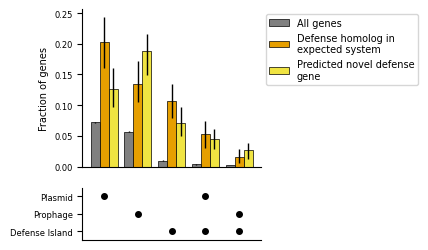

In [33]:
plot_upset(
    merged_hit_loc_agg_df[merged_hit_loc_agg_df['Defense Island'] | 
                          merged_hit_loc_agg_df['Plasmid'] |
                          merged_hit_loc_agg_df['Prophage']].reset_index(drop=True), 
    ['Defense Island', 'Prophage', 'Plasmid'], 'hit_cat_frac', 'hit_category',
    figsize=(2.3, 3),
    palette=defense_type_palette,  # Custom color palette
    subplot_fraction=0.25,           # Subplot is 25% of the bar plot height
    lower_bound='lower_bound_lb',
    upper_bound='hit_cat_frac_ub',
    legend_title=None, bar_ylabel='Fraction of genes', 
    marker_size=4, legend_text_width=25
)
plt.savefig('../figures/hit_type_distribution.svg', bbox_inches='tight', dpi=300)